In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd gdrive/My Drive/ColabNotebooks/proportional_ink

/content/gdrive/My Drive/ColabNotebooks/proportional_ink


In [0]:
import keras
import numpy as np
from keras.applications import resnet50
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import glob
import random

Using TensorFlow backend.


In [0]:
! ls

sample_data


In [0]:
bar_path = glob.glob(r'./barcharts/bar/*')
not_path = glob.glob(r'./barcharts/not/*')
print(bar_path)
bar_files = [f for f in bar_path]
print(len(bar_files))
not_files = [f for f in not_path]
print(len(not_files))


['./barcharts/bar/PMC2974736_1471-2407-10-574-2.jpg', './barcharts/bar/PMC2958130_pone.0013518.g001.jpg', './barcharts/bar/PMC2974736_1471-2407-10-574-3.jpg', './barcharts/bar/PMC2974736_1471-2407-10-574-4.jpg', './barcharts/bar/PMC2974649_pone.0013840.g005.jpg', './barcharts/bar/PMC2974736_1471-2407-10-574-5.jpg', './barcharts/bar/PMC2976758_1471-2105-11-534-1.jpg', './barcharts/bar/PMC2989954_1471-213X-10-110-7.jpg', './barcharts/bar/PMC2987996_1744-8069-6-71-5.jpg', './barcharts/bar/PMC2987762_1743-8454-7-18-7.jpg', './barcharts/bar/PMC2990821_IJPsy-52-220-g002.jpg', './barcharts/bar/PMC2978316_330_2010_1869_Fig4_HTML.jpg', './barcharts/bar/PMC2987762_1743-8454-7-18-4.jpg', './barcharts/bar/PMC2981554_pone.0013988.g004.jpg', './barcharts/bar/PMC2987996_1744-8069-6-71-2.jpg', './barcharts/bar/PMC2988991_12263_2010_187_Fig7_HTML.jpg', './barcharts/bar/PMC2990821_IJPsy-52-220-g003.jpg', './barcharts/bar/PMC2992047_1475-2859-9-84-5.jpg', './barcharts/bar/PMC2992848_10519_2010_9350_Fig3_

In [0]:
bar_images = [img_to_array(load_img(image, target_size = (244, 244))) for image in bar_files]
not_images = [img_to_array(load_img(image, target_size = (244, 244))) for image in not_files]

In [0]:
np.save('bar',bar_images)
np.save('bar-neg',not_images)

In [0]:
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, accuracy_score
from keras import optimizers
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [0]:
def get_data_binary(diagram_type):
  pos = np.load('%s.npy'%diagram_type)
  n_pos = pos.shape[0]
  neg = np.load('%s-neg.npy'%diagram_type)
  n_neg = neg.shape[0]
  print(n_pos,n_neg)
  X = np.vstack((pos,neg))
  print(X.shape)
  y = np.vstack((np.ones((n_pos,1), dtype = np.float64), np.zeros((n_neg,1), dtype=np.float64)))
  print(y.shape)
  tr_val_x, test_x, tr_val_y, test_y = train_test_split(X,y, test_size=0.1,random_state=1)
  train_x, valid_x, train_y, valid_y = train_test_split(tr_val_x, tr_val_y, test_size=0.1, random_state=2)
  return (train_x,train_y), (test_x,test_y), (valid_x,valid_y)

In [0]:
(train_x, train_y), (test_x, test_y), (valid_x,valid_y) = get_data_binary('bar')
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape,valid_x.shape, valid_y.shape)

1284 1188
(2472, 244, 244, 3)
(2472, 1)
(2001, 244, 244, 3) (2001, 1) (248, 244, 244, 3) (248, 1) (223, 244, 244, 3) (223, 1)


In [0]:
train_y = to_categorical(train_y)
print(train_y.shape)
valid_y = to_categorical(valid_y)
print(valid_y.shape)

(2001, 2)
(223, 2)


In [0]:
resnet_model = resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = (244,244,3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


In [0]:
x = resnet_model.output
x = layers.Flatten()(x)
resnet = models.Model(resnet_model.input, output = x)
for layer in resnet.layers:
  layer.trainable = True
resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 244, 244, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 250, 250, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 122, 122, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 122, 122, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
model = models.Sequential()


# Input - Layer
model.add(resnet)
model.add(layers.Dense(500, activation = "relu", input_shape=(2048, )))
# Hidden - Layers
model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(200, activation = "relu"))
model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(10, activation = "relu"))
model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(2, activation = "softmax"))
model.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 131072)            23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 500)               65536500  
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2010      
____

In [0]:
sgd = optimizers.SGD(lr=0.0001, decay=1e-2, momentum=0.9)
# compiling the model
model.compile(
 optimizer = 'sgd',
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_x, train_y,
 epochs= 100,
 batch_size = 32,
 validation_data = (valid_x, valid_y)
)
y_pred = model.predict(test_x)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2001 samples, validate on 223 samples
Epoch 1/100
2001/2001 [==============================] - 82s 41ms/step - loss: 0.4255 - acc: 0.8191 - val_loss: 0.2940 - val_acc: 0.9193
Epoch 2/100
2001/2001 [==============================] - 64s 32ms/step - loss: 0.1753 - acc: 0.9370 - val_loss: 0.1366 - val_acc: 0.9686
Epoch 3/100
2001/2001 [==============================] - 64s 32ms/step - loss: 0.0900 - acc: 0.9685 - val_loss: 0.1536 - val_acc: 0.9596
Epoch 4/100
2001/2001 [==============================] - 64s 32ms/step - loss: 0.0547 - acc: 0.9850 - val_loss: 0.2118 - val_acc: 0.9507
Epoch 5/100
2001/2001 [==============================] - 64s 32ms/step - loss: 0.0251 - acc: 0.9915 - val_loss: 0.2110 - val_acc: 0.9552
Epoch 6/100
2001/2001 [==============================] - 64s 32ms/step - loss: 0.0200 - acc: 0.9925 - val_loss: 0.2406 - val_acc: 0.9686
Epoch 7/100
2001/2001 [==========

In [0]:
print((y_pred.argmax(axis=1)).shape)
print(pred_y.shape)
print(test_y.shape)

(248,)
(248, 1)
(248, 1)


In [0]:
cm = confusion_matrix(test_y, y_pred.argmax(axis = 1))
print (cm)
model.save('models/classifybars.h5')
print("Test-Accuracy:", accuracy_score(test_y, y_pred.argmax(axis = 1)))

[[113   7]
 [  4 124]]
Test-Accuracy: 0.9556451612903226


In [0]:
pred_y = (y_pred.argmax(axis=1))
ntest_y = test_y.reshape(-1,)
fp = test_x[np.where(np.logical_and(pred_y != ntest_y, pred_y == 1))]
fn = test_x[np.where(np.logical_and(pred_y != ntest_y, pred_y == 0))]
print(fp.shape, fn.shape)

(7, 244, 244, 3) (4, 244, 244, 3)


In [0]:
from PIL import Image

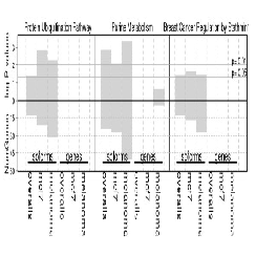

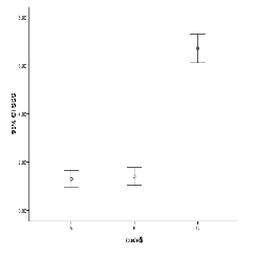

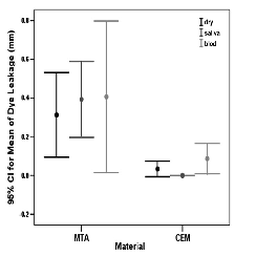

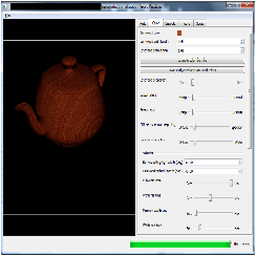

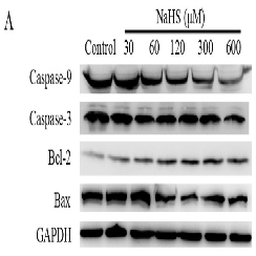

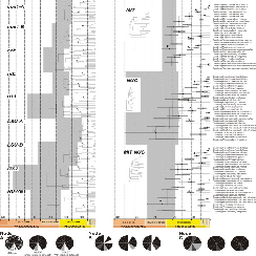

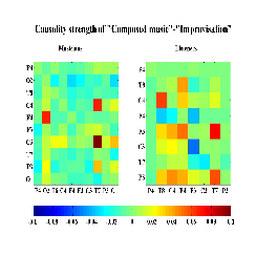

In [0]:
for fpi in fp:
  image = Image.fromarray(np.uint8(fpi))
  display(image.resize((256,256), Image.LANCZOS))
 

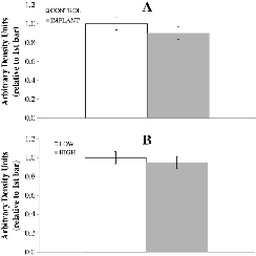

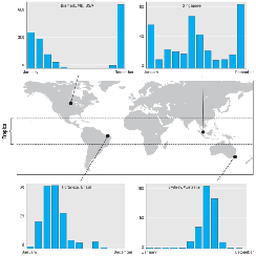

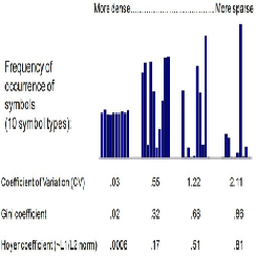

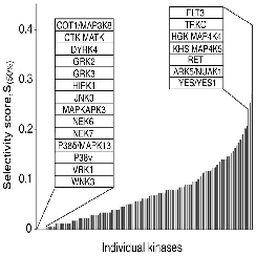

In [0]:
for fni in fn:
  image = Image.fromarray(np.uint8(fni))
  display(image.resize((256,256), Image.LANCZOS))

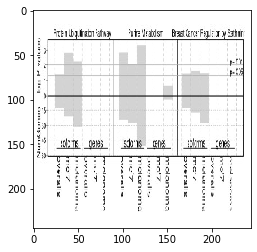

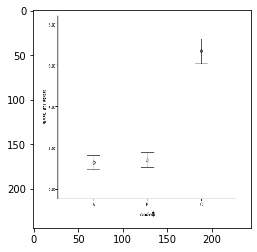

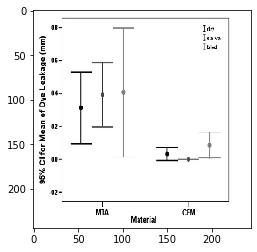

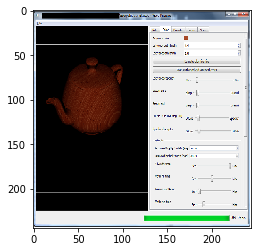

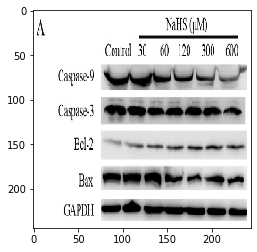

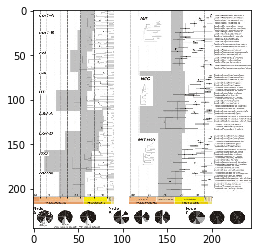

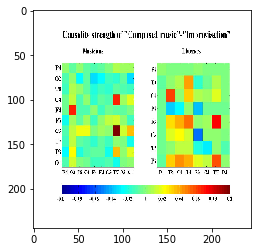

In [0]:
for i in fp:
  plt.imshow(i/255, interpolation='nearest')
  plt.show()

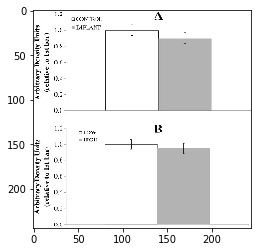

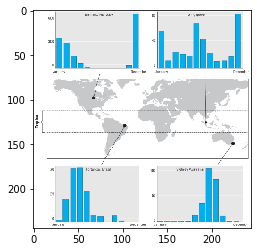

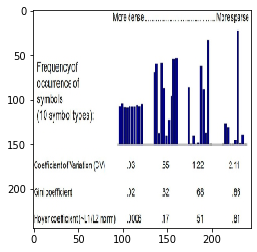

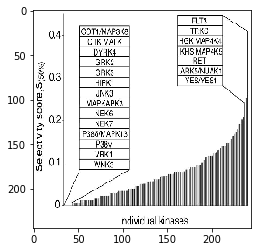

In [0]:
for i in fn:
  plt.imshow(i/255, interpolation='nearest')
  plt.show()